In [1]:
%run SAT_help_functions.ipynb
%matplotlib inline

In [2]:
## save dataframe for each frequency levels
data_dir = "/Users/wangjiashun/Desktop/Reserach on SAT/datasets/Lexical Decision Data/SpeedAccData.csv"
save_dir = '/Users/wangjiashun/Desktop/Reserach on SAT/datasets/Lexical Decision Data/dataByFreq/Freq'
df = pd.read_csv(data_dir)
Frequencies = [1,  2, 3,  4,  5,  6]
participants = [1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17]

for freq in Frequencies:
    data_freq = df[df.loc[:,'Frequency']==freq]
    for sub in range(sample_size):
        data_freq_sub = data_freq[data_freq.loc[:,'Participant']==participants[sub]]
        data_freq_sub.to_csv(save_dir+str(freq)+'/sub'+str(sub+1)+'.csv')
    

NameError: name 'sample_size' is not defined

In [2]:
data_dir = "/Users/wangjiashun/Desktop/Reserach on SAT/datasets/Lexical Decision Data/dataByFreq/Freq"
sample_size = 16
correct = 'Correct'
corrects = [1, 0]
cond = 'SAT' 
conds = [1, 2]
rt = 'RT'

participants = [1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17]

model = 'DDM2v2a2ter'
dataset = 'Wagenmakers2008'
params_all = pd.read_csv(model+"result"+dataset+".csv")# .drop(labels=3, axis=0)

In [3]:
def get_RT_quantile_sub(df, correct, corrects, cond, conds, rt, quantiles = [.1, .3, .5, .7, .9]):
    
    # RT quantiles
    df_cor = df.loc[df[correct]==corrects[0]]
    RT_cor_s = df_cor.loc[df_cor[cond]==conds[0]][rt].quantile(q=quantiles)
    RT_cor_a = df_cor.loc[df_cor[cond]==conds[1]][rt].quantile(q=quantiles)

    df_err = df.loc[df[correct]==corrects[1]]
    RT_err_s = df_err.loc[df_err[cond]==conds[0]][rt].quantile(q=quantiles)
    RT_err_a = df_err.loc[df_err[cond]==conds[1]][rt].quantile(q=quantiles)
    
    # number of trials
    num_cor_s = len(df_cor.loc[df_cor[cond]==conds[0]])
    num_cor_a = len(df_cor.loc[df_cor[cond]==conds[1]])

    num_err_s = len(df_err.loc[df_err[cond]==conds[0]])
    num_err_a = len(df_err.loc[df_err[cond]==conds[1]])
    #print(df.loc[:,"Participant"])
    #print(RT_cor_s)
    #print(RT_cor_a)
    return RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, [num_cor_s,num_cor_a,num_err_s,num_err_a]



In [4]:
#get_RT_quantile_sub(df = df, rt = rt, correct = correct, corrects = corrects, cond = cond, conds = conds)

In [5]:
def get_RT_quantile(data_dir, sample_size, correct, corrects, cond, conds, rt, quantiles = [.1, .3, .5, .7, .9]):

    RT_cor_ss, RT_cor_as, RT_err_ss, RT_err_as, nums = np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,4))
    for i in range(sample_size):
        path = os.path.join(data_dir+str(i+1)+".csv")
        df = pd.read_csv(path, sep = ",")
        #print(df)
        RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, num = get_RT_quantile_sub(
            df = df, rt = rt,
            correct = correct, corrects = corrects,
            cond = cond, conds = conds)
        #print(RT_cor_s)
        RT_cor_ss[i,:] = RT_cor_s
        RT_cor_as[i,:] = RT_cor_a
        RT_err_ss[i,:] = RT_err_s
        RT_err_as[i,:] = RT_err_a
        nums[i,:] = num
    
    return RT_cor_ss.mean(axis = 0), RT_cor_as.mean(axis = 0), RT_err_ss.mean(axis = 0), RT_err_as.mean(axis = 0), nums.mean(axis = 0)


In [6]:
#data_dir = "/Users/wangjiashun/Desktop/Reserach on SAT/datasets/Lexical Decision Data/dataByFreq/Freq1/sub"

#RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = get_RT_quantile(data_dir = data_dir,sample_size= sample_size, correct = correct, corrects = corrects,
#        cond = cond, conds = conds, rt = rt)

In [6]:
#params = np.array(params_all)[0,1:6]

class DriftBothSpeedAcc(Drift):
    name = "DriftBothSpeedAcc"
    required_parameters = ["Vspeed","Vacc", "Kspeed", "Kacc"]
    required_conditions = ['SAT']
        
    def get_drift(self, x, t, conditions, **kwargs):
        if conditions['SAT'] == 1:
            return self.Vspeed + x*self.Kspeed 
        elif conditions['SAT'] == 2:
            return self.Vacc + x*self.Kacc
        else: 
            print("Non-implemented SAT conditions")
            
class DriftConstantSpeedAcc(Drift):
    name = "DriftConstantSpeedAcc"
    required_parameters = ["Vspeed","Vacc"]
    required_conditions = ['SAT']
        
    def get_drift(self, x, t, conditions, **kwargs):
        if conditions['SAT'] == 1:
            return self.Vspeed
        elif conditions['SAT'] == 2:
            return self.Vacc
        else: 
            print("Non-implemented SAT conditions")

class DriftExcitationSpeedAcc(Drift):
    name = "DriftSpeedAcc"
    required_parameters = ["drift", "Kspeed", "Kacc"]
    required_conditions = ['SAT']
        
    def get_drift(self, x, t, conditions, **kwargs):
        if conditions['SAT'] == 1:
            return self.drift + x*self.Kspeed 
        elif conditions['SAT'] == 2:
            return self.drift + x*self.Kacc
        else: 
            print("Non-implemented SAT conditions")

class BoundSpeedAcc(Bound):
    name = "BoundSpeedAcc"
    required_parameters = ["Bspeed", "Bacc"]
    required_conditions = ['SAT']
    def get_bound(self, conditions, *args, **kwargs):
        if conditions['SAT'] == 1:
            return self.Bspeed
        elif conditions['SAT'] == 2:
            return self.Bacc
        else:
            print("Non-implemented SAT conditions")
            
class NondecisionSpeedAcc(OverlayNonDecision):
    name = "NondecisionSpeedAcc"
    required_parameters = ["tSpeed", 'tAcc']
    required_conditions = ['SAT']
        
    def get_nondecision_time(self, conditions, **kwargs):
        if conditions['SAT'] == 1:
            return self.tSpeed 
        elif conditions['SAT'] == 2:
            return self.tAcc
        else: 
            print("Non-implemented SAT conditions")

def get_RT_quantile_DDM_sub(params, T_dur=3):

    Vspeed,Vacc, Bspeed,Bacc,tSpeed,tAcc = params[0],params[1],params[2],params[3],params[4],params[5]

    model = Model(name='Simple model (fitted)',
                      drift=DriftConstantSpeedAcc(Vspeed=Vspeed, Vacc=Vacc), 
                      noise=NoiseConstant(noise=1),
                      bound=BoundSpeedAcc(Bspeed=Bspeed,Bacc=Bacc),
                      overlay=NondecisionSpeedAcc(tSpeed=tSpeed,tAcc=tAcc),
                      dx=.001, dt=.001, T_dur=T_dur)
    sol_s = model.solve({'SAT':1})
    samp_s = sol_s.resample(1000)
    data_s = samp_s.to_pandas_dataframe(drop_undecided = True)

    sol_a = model.solve({'SAT':2})
    samp_a = sol_a.resample(1000)
    data_a = samp_a.to_pandas_dataframe(drop_undecided = True)

    data = pd.concat((data_s, data_a))

    return get_RT_quantile_sub(data, 'choice', [1,0], 'SAT', [1, 2], 'RT')
#get_RT_quantile_DDM_sub(params = np.array(params_all)[3,1:6])

In [8]:
#np.array(params_all)[3,1:6]

In [7]:
def get_RT_quantile_DDM(params_all, sample_size, correct, corrects, cond, conds, rt, quantiles = [.1, .3, .5, .7, .9]):

    RT_cor_ss, RT_cor_as, RT_err_ss, RT_err_as, nums = np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,4))
    for i in range(sample_size):
        #print(i)
        params = np.array(params_all)[i,1:7]
        
        
        RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, num = get_RT_quantile_DDM_sub(params = params)
        #print(RT_err_a)
        RT_cor_ss[i,:] = RT_cor_s
        RT_cor_as[i,:] = RT_cor_a
        RT_err_ss[i,:] = RT_err_s
        RT_err_as[i,:] = RT_err_a
        nums[i,:] = num
    
    return np.nanmean(RT_cor_ss, axis = 0), np.nanmean(RT_cor_as, axis = 0), np.nanmean(RT_err_ss, axis = 0), np.nanmean(RT_err_as, axis = 0), np.nanmean(nums, axis = 0)



In [10]:
RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = get_RT_quantile_DDM(params_all = params_all[params_all.loc[:,'Frequency']==1],
                                                                   sample_size= sample_size, correct = correct, corrects = corrects,
        cond = cond, conds = conds, rt = rt)

In [11]:
Frequencies = [1,  2, 3,  4,  5,  6]


<Axes: xlabel='Probability of Response', ylabel='RT'>

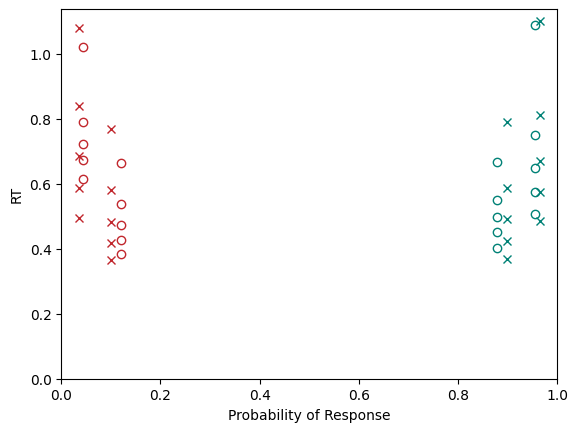

In [9]:
def DDM_QP_plot(ax=None):
    if ax is None:
        ax = plt.gca()
    
    quantiles = [.1, .3, .5, .7, .9]
    ## behavioral data
    
    for freq in [6]:
        data_dir = "/Users/wangjiashun/Desktop/Reserach on SAT/datasets/Lexical Decision Data/dataByFreq/Freq"+str(freq)+"/sub"    
        
        RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = get_RT_quantile(data_dir = data_dir,sample_size= sample_size, 
                                                                       correct = correct, corrects = corrects,
                                                                       cond = cond, conds = conds, rt = rt)

        ax.plot([nums[0]/(nums[0]+nums[2])]*5, RT_cor_s,"o", color = '#008176', fillstyle = 'none')
        ax.plot([nums[1]/(nums[1]+nums[3])]*5, RT_cor_a,"o", color = '#008176', fillstyle = 'none')
        ax.plot([nums[2]/(nums[0]+nums[2])]*5, RT_err_s,"o", color = '#c1272d', fillstyle = 'none')
        ax.plot([nums[3]/(nums[1]+nums[3])]*5, RT_err_a,"o", color = '#c1272d', fillstyle = 'none')

        ## data generated from model
        RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = get_RT_quantile_DDM(params_all = params_all[params_all.loc[:,'Frequency']==freq]
                                                                           ,sample_size= sample_size, 
                                                                       correct = correct, corrects = corrects,
                                                                       cond = cond, conds = conds, rt = rt)

        ax.plot([nums[0]/(nums[0]+nums[2])]*5, RT_cor_s,"x", color = '#008176', fillstyle = 'none')
        ax.plot([nums[1]/(nums[1]+nums[3])]*5, RT_cor_a,"x", color = '#008176', fillstyle = 'none')
        ax.plot([nums[2]/(nums[0]+nums[2])]*5, RT_err_s,"x", color = '#c1272d', fillstyle = 'none')
        ax.plot([nums[3]/(nums[1]+nums[3])]*5, RT_err_a,"x", color = '#c1272d', fillstyle = 'none')

    # limits
    ax.set_xlim(0,1)
    ax.set_ylim(0,)
        
    ax.set_xlabel("Probability of Response")
    ax.set_ylabel("RT")
    return(ax)
DDM_QP_plot()

In [19]:
model = 'OUM2v2k2ter'
dataset = 'Wagenmakers2008'
params_all = pd.read_csv(model+"result"+dataset+".csv")#.drop(labels=3, axis=0)


In [8]:

            
def get_RT_quantile_OUM2v2k2ter_sub(params, T_dur=3):

    Vspeed,Vacc, Kspeed,Kacc,B,tSpeed,tAcc = params[0],params[1],params[2],params[3],params[4],params[5],params[6]

    model = Model(name='Simple model (fitted)',
                      drift=DriftBothSpeedAcc(Vspeed=Vspeed, Vacc=Vacc, Kspeed=Kspeed, Kacc=Kacc),                              
                      noise=NoiseConstant(noise=1),
                      bound=BoundConstant(B=B),
                      overlay=NondecisionSpeedAcc(tSpeed=tSpeed,tAcc=tAcc),
                      dx=.001, dt=.001, T_dur=T_dur)
    sol_s = model.solve({'SAT':1})
    samp_s = sol_s.resample(1000)
    data_s = samp_s.to_pandas_dataframe(drop_undecided = True)

    sol_a = model.solve({'SAT':2})
    samp_a = sol_a.resample(1000)
    data_a = samp_a.to_pandas_dataframe(drop_undecided = True)

    data = pd.concat((data_s, data_a))

    return get_RT_quantile_sub(data, 'choice', [1,0], 'SAT', [1, 2], 'RT')
#get_RT_quantile_OUM2v2k2ter_sub(params = np.array(params_all)[0,1:8])

In [9]:
def get_RT_quantile_OUM2v2k2ter(params_all, sample_size, correct, corrects, cond, conds, rt, quantiles = [.1, .3, .5, .7, .9]):

    RT_cor_ss, RT_cor_as, RT_err_ss, RT_err_as, nums = np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,4))
    for i in range(sample_size):

        params = np.array(params_all)[i,1:8]
        RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, num = get_RT_quantile_OUM2v2k2ter_sub(params = params)
        #print(RT_err_a)
        RT_cor_ss[i,:] = RT_cor_s
        RT_cor_as[i,:] = RT_cor_a
        RT_err_ss[i,:] = RT_err_s
        RT_err_as[i,:] = RT_err_a
        nums[i,:] = num
    
    return np.nanmean(RT_cor_ss, axis = 0), np.nanmean(RT_cor_as, axis = 0), np.nanmean(RT_err_ss, axis = 0), np.nanmean(RT_err_as, axis = 0), np.nanmean(nums, axis = 0)

RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = get_RT_quantile_OUM2v2k2ter(params_all = params_all,sample_size= sample_size, correct = correct, corrects = corrects,
        cond = cond, conds = conds, rt = rt)

/var/folders/5g/vqmn12yd48z6l6jf2s2yy62r0000gn/T/ipykernel_77565/2303720293.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat((data_s, data_a))
/var/folders/5g/vqmn12yd48z6l6jf2s2yy62r0000gn/T/ipykernel_77565/2303720293.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat((data_s, data_a))
/var/folders/5g/vqmn12yd48z6l6jf2s2yy62r0000gn/T/ipykernel_77565/2303720293.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is de

/var/folders/5g/vqmn12yd48z6l6jf2s2yy62r0000gn/T/ipykernel_12523/2303720293.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat((data_s, data_a))
/var/folders/5g/vqmn12yd48z6l6jf2s2yy62r0000gn/T/ipykernel_12523/2303720293.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat((data_s, data_a))
/var/folders/5g/vqmn12yd48z6l6jf2s2yy62r0000gn/T/ipykernel_12523/2303720293.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is de

FloatingPointError: invalid value encountered in scalar divide

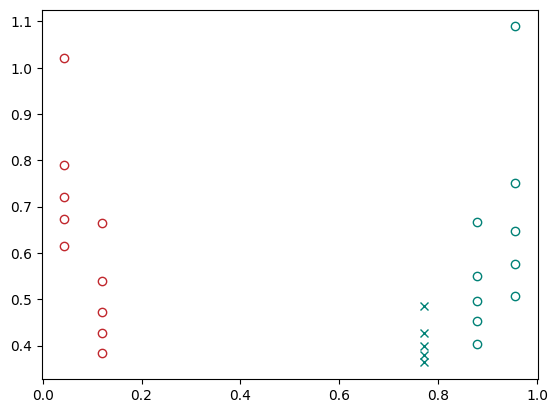

In [15]:
def OUM2v2k2ter_QP_plot(ax=None):
    if ax is None:
        ax = plt.gca()
    
    quantiles = [.1, .3, .5, .7, .9]
    
    for freq in [6]:
        data_dir = "/Users/wangjiashun/Desktop/Reserach on SAT/datasets/Lexical Decision Data/dataByFreq/Freq"+str(freq)+"/sub"    

        ## behavioral data
        RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = get_RT_quantile(data_dir = data_dir,sample_size= sample_size, 
                                                                       correct = correct, corrects = corrects,
                                                                       cond = cond, conds = conds, rt = rt)

        ax.plot([nums[0]/(nums[0]+nums[2])]*5, RT_cor_s,"o", color = '#008176', fillstyle = 'none')
        ax.plot([nums[1]/(nums[1]+nums[3])]*5, RT_cor_a,"o", color = '#008176', fillstyle = 'none')
        ax.plot([nums[2]/(nums[0]+nums[2])]*5, RT_err_s,"o", color = '#c1272d', fillstyle = 'none')
        ax.plot([nums[3]/(nums[1]+nums[3])]*5, RT_err_a,"o", color = '#c1272d', fillstyle = 'none')

        ## data generated from model
        RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = get_RT_quantile_OUM2v2k2ter(params_all = params_all[params_all.loc[:,'Frequency']==freq],
                                                                                   sample_size= sample_size, 
                                                                       correct = correct, corrects = corrects,
                                                                       cond = cond, conds = conds, rt = rt)

        ax.plot([nums[0]/(nums[0]+nums[2])]*5, RT_cor_s,"x", color = '#008176', fillstyle = 'none')
        ax.plot([nums[1]/(nums[1]+nums[3])]*5, RT_cor_a,"x", color = '#008176', fillstyle = 'none')
        ax.plot([nums[2]/(nums[0]+nums[2])]*5, RT_err_s,"x", color = '#c1272d', fillstyle = 'none')
        ax.plot([nums[3]/(nums[1]+nums[3])]*5, RT_err_a,"x", color = '#c1272d', fillstyle = 'none')

    # limits
    ax.set_xlim(0,1)
    ax.set_ylim(0,)
        
    ax.set_xlabel("Probability of Response")
    ax.set_ylabel("RT")
    return(ax)
OUM2v2k2ter_QP_plot()

In [18]:
params_DDM = pd.read_csv("DDM2v2a2terresult"+dataset+".csv")
params_DDM = params_DDM[params_DDM['Frequency']==freq]

,Unnamed: 0,Drift Rate Speed,Drift Rate Accuracy,Boundary Separation Speed,Boundary Separation Accuracy,Non-decision Time Speed,Non-decision Time Accuracy,BIC,Frequency,Participant
0,0,2.837831,3.697783,0.521162,0.546555,0.350671,0.375589,-269.963183,1,1
1,0,2.528667,2.257942,0.500000,0.649245,0.372407,0.359372,-132.271001,2,1
2,0,0.918880,1.707032,0.511457,0.556873,0.340197,0.386679,-14.115949,3,1
3,0,2.255968,2.748231,0.505303,0.500000,0.346223,0.396072,-175.024073,4,1
4,0,2.996331,2.476471,0.565188,0.569583,0.350860,0.366813,-171.276071,5,1
...,...,...,...,...,...,...,...,...,...,...
91,0,2.581261,2.441877,0.719825,0.948569,0.309301,0.391413,-175.966176,2,17
92,0,1.689904,1.664640,0.575485,0.738798,0.325510,0.453987,8.237974,3,17
93,0,2.167137,2.655667,0.693316,1.067932,0.302200,0.406330,-124.586036,4,17
94,0,2.495757,2.255576,0.700445,0.943568,0.324428,0.407560,-131.371126,5,17


In [19]:
def DDM_OUM_QP_plot(dataset,sample_size, 
                        correct, corrects,
                        cond, conds, rt, freq,label,
                        ax=None):
    if ax is None:
        ax = plt.gca()
    
    quantiles = [.1, .3, .5, .7, .9]
    for freq in [freq]:
        data_dir = "/Users/wangjiashun/Desktop/Reserach on SAT/datasets/Lexical Decision Data/dataByFreq/Freq"+str(freq)+"/sub"    

        ## behavioral data
        RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = get_RT_quantile(data_dir = data_dir,sample_size= sample_size, 
                                                                       correct = correct, corrects = corrects,
                                                                       cond = cond, conds = conds, rt = rt)
        #print(RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums)
        ax.plot([nums[0]/(nums[0]+nums[2])]*5, RT_cor_s,"o", color = 'black', fillstyle = 'none')
        ax.plot([nums[1]/(nums[1]+nums[3])]*5, RT_cor_a,"o", color = 'black', fillstyle = 'none')
        ax.plot([nums[2]/(nums[0]+nums[2])]*5, RT_err_s,"o", color = 'black', fillstyle = 'none')
        ax.plot([nums[3]/(nums[1]+nums[3])]*5, RT_err_a,"o", color = 'black', fillstyle = 'none')

        ## data generated from DDM
        params_DDM = pd.read_csv("DDM2v2a2terresult"+dataset+".csv")#.drop(labels=3, axis=0)
        params_DDM = params_DDM[params_DDM['Frequency']==freq]
        RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = get_RT_quantile_DDM(params_all = params_DDM,sample_size= sample_size, 
                                                                       correct = correct, corrects = corrects,
                                                                       cond = cond, conds = conds, rt = rt)
        #print(RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums)

        ax.plot([nums[0]/(nums[0]+nums[2])]*5, RT_cor_s,"x", color = '#008176', fillstyle = 'none')
        ax.plot([nums[1]/(nums[1]+nums[3])]*5, RT_cor_a,"x", color = '#008176', fillstyle = 'none')
        ax.plot([nums[2]/(nums[0]+nums[2])]*5, RT_err_s,"x", color = '#008176', fillstyle = 'none')
        ax.plot([nums[3]/(nums[1]+nums[3])]*5, RT_err_a,"x", color = '#008176', fillstyle = 'none')

        ## data generated from OUM
        params_OUM = pd.read_csv("OUM2v2k2terresult"+dataset+".csv")#.drop(labels=3, axis=0)
        params_OUM = params_OUM[params_OUM['Frequency']==freq]
        RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = get_RT_quantile_OUM2v2k2ter(params_all = params_OUM,sample_size= sample_size, 
                                                                       correct = correct, corrects = corrects,
                                                                       cond = cond, conds = conds, rt = rt)
        ax.plot([nums[0]/(nums[0]+nums[2])]*5, RT_cor_s,"x", color = '#c1272d', fillstyle = 'none')
        ax.plot([nums[1]/(nums[1]+nums[3])]*5, RT_cor_a,"x", color = '#c1272d', fillstyle = 'none')
        ax.plot([nums[2]/(nums[0]+nums[2])]*5, RT_err_s,"x", color = '#c1272d', fillstyle = 'none')
        ax.plot([nums[3]/(nums[1]+nums[3])]*5, RT_err_a,"x", color = '#c1272d', fillstyle = 'none')
    
    # limits
    ax.set_xlim(0,1)
    ax.set_ylim(0,)
    #ax.set_xlabel("Probability of Response")
    ax.set_ylabel("RT")
    ax.set_title(label)

    #ax.legend(loc = 'upper right')
    return(ax)


<Axes: title={'center': 'Very Low Frequency Nonword'}, ylabel='RT'>

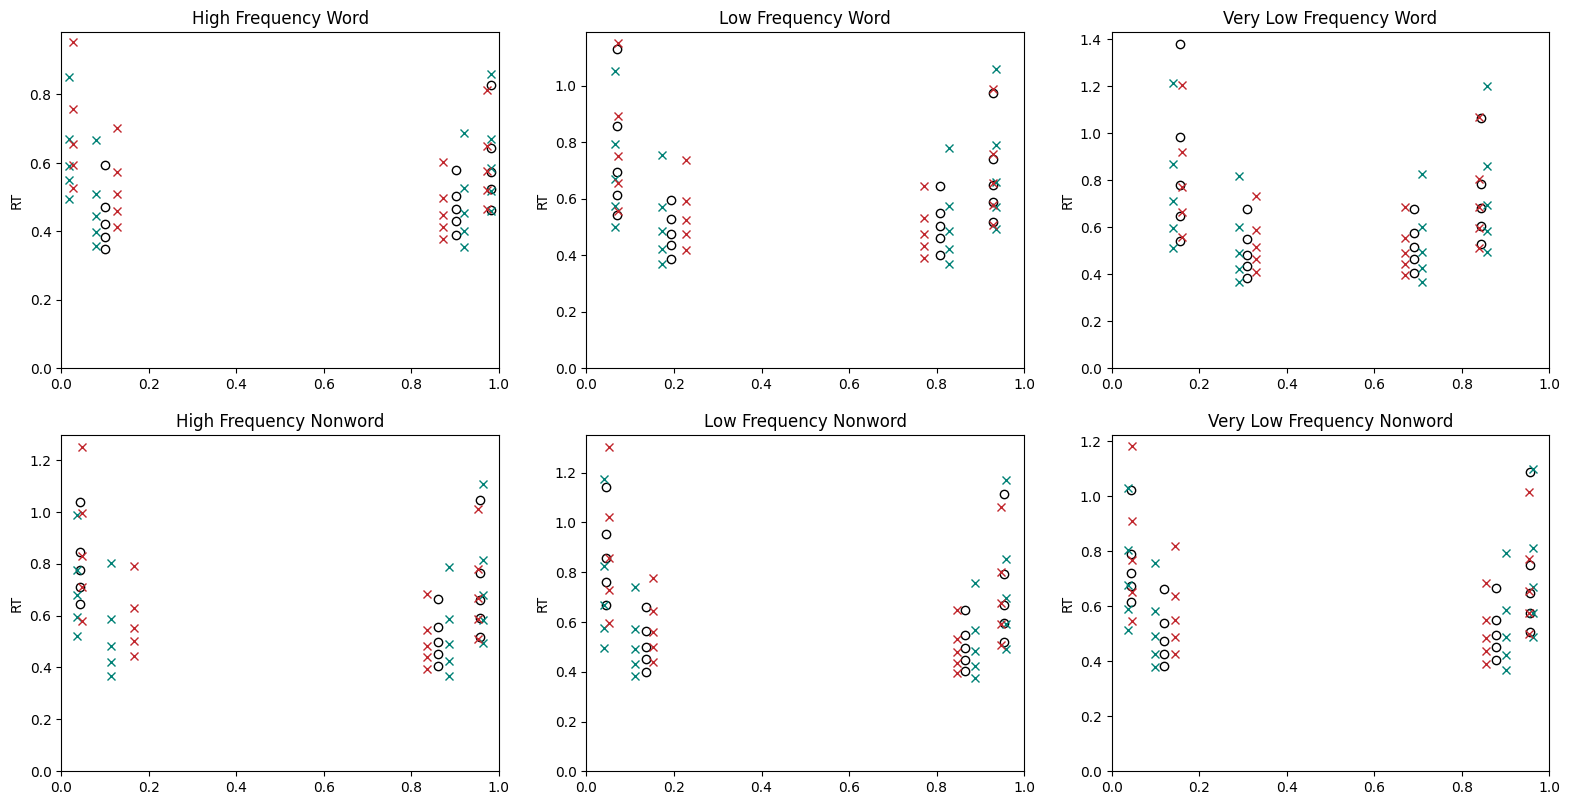

In [20]:
fig, ax = plt.subplots(2,3,figsize=[6.4*3, 4.8*2])


DDM_OUM_QP_plot(dataset,sample_size, correct, corrects, cond, conds, rt, 1,"High Frequency Word", ax = ax[0,0])
DDM_OUM_QP_plot(dataset,sample_size, correct, corrects, cond, conds, rt, 2,"Low Frequency Word", ax = ax[0,1])
DDM_OUM_QP_plot(dataset,sample_size, correct, corrects, cond, conds, rt, 3,"Very Low Frequency Word", ax = ax[0,2])
DDM_OUM_QP_plot(dataset,sample_size, correct, corrects, cond, conds, rt, 4,"High Frequency Nonword", ax = ax[1,0])
DDM_OUM_QP_plot(dataset,sample_size, correct, corrects, cond, conds, rt, 5,"Low Frequency Nonword", ax = ax[1,1])
DDM_OUM_QP_plot(dataset,sample_size, correct, corrects, cond, conds, rt, 6,"Very Low Frequency Nonword", ax = ax[1,2])

<Axes: title={'center': 'Very Low Frequency Nonword'}, ylabel='RT'>

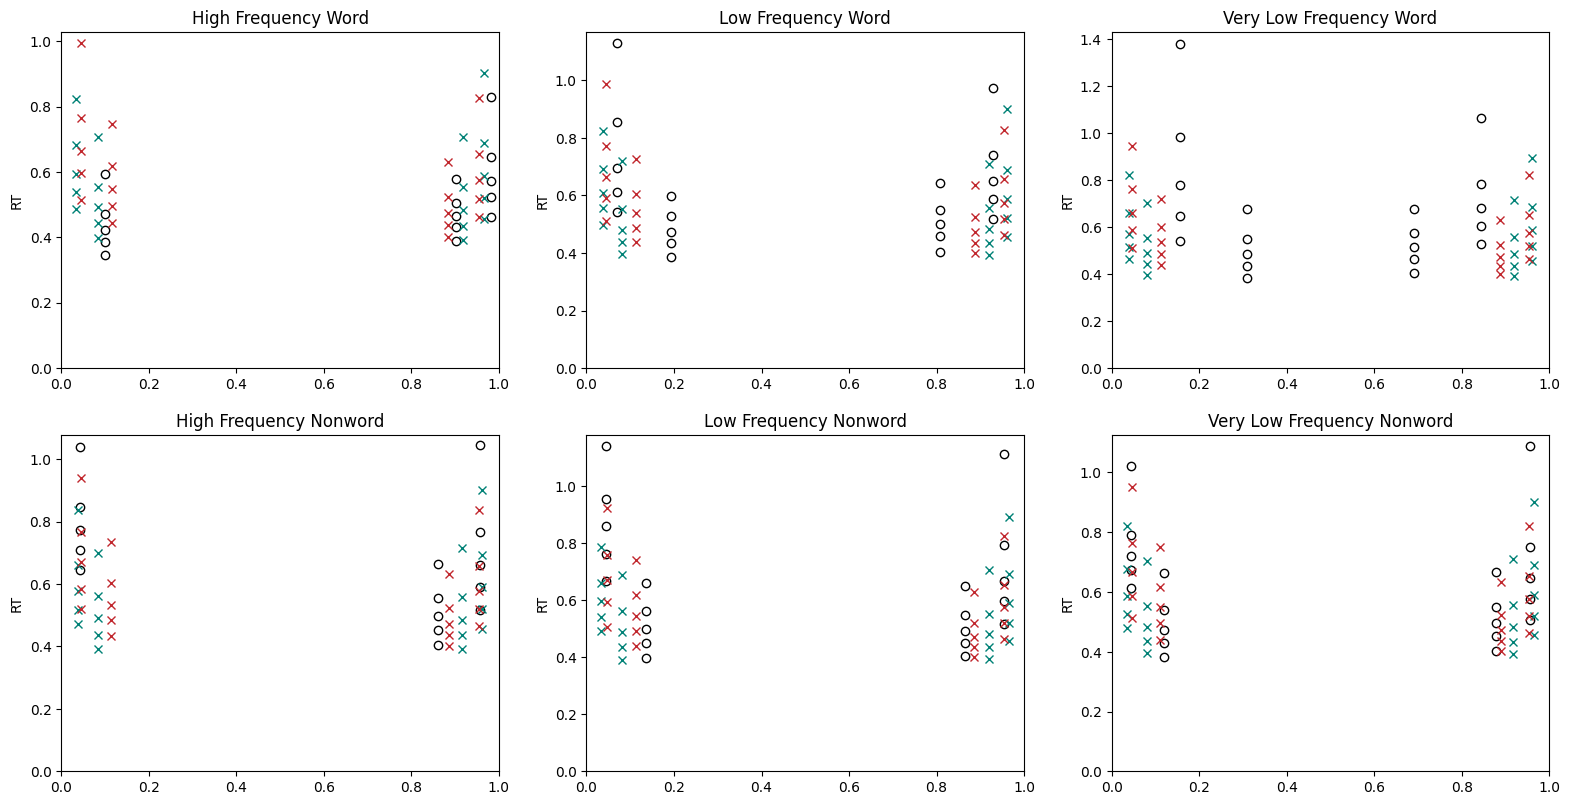

In [175]:
# incorrect, using the same model prediction for all subplots
fig, ax = plt.subplots(2,3,figsize=[6.4*3, 4.8*2])


DDM_OUM_QP_plot(dataset,sample_size, correct, corrects, cond, conds, rt, 1,"High Frequency Word", ax = ax[0,0])
DDM_OUM_QP_plot(dataset,sample_size, correct, corrects, cond, conds, rt, 2,"Low Frequency Word", ax = ax[0,1])
DDM_OUM_QP_plot(dataset,sample_size, correct, corrects, cond, conds, rt, 3,"Very Low Frequency Word", ax = ax[0,2])
DDM_OUM_QP_plot(dataset,sample_size, correct, corrects, cond, conds, rt, 4,"High Frequency Nonword", ax = ax[1,0])
DDM_OUM_QP_plot(dataset,sample_size, correct, corrects, cond, conds, rt, 5,"Low Frequency Nonword", ax = ax[1,1])
DDM_OUM_QP_plot(dataset,sample_size, correct, corrects, cond, conds, rt, 6,"Very Low Frequency Nonword", ax = ax[1,2])

In [142]:
quantiles_data,quantiles_DDM,quantiles_OUM =[],[],[]
for freq in Frequencies:
    data_dir = "/Users/wangjiashun/Desktop/Reserach on SAT/datasets/Lexical Decision Data/dataByFreq/Freq"+str(freq)+"/sub"    

    ## data generated from DDM
    RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = get_all_RT_quantile(data_dir = data_dir,sample_size= sample_size, 
                                                                   correct = correct, corrects = corrects,
                                                                   cond = cond, conds = conds, rt = rt)
    quantiles_data.append(pd.DataFrame({"cor_s":RT_cor_s[:,4]/RT_cor_s[:,2],
                                   "cor_a":RT_cor_a[:,4]/RT_cor_a[:,2], 
                                   "err_s": RT_err_s[:,4]/RT_err_s[:,2],
                                   "err_a": RT_err_a[:,4]/RT_err_a[:,2]}))

    ## data generated from DDM
    params_DDM = pd.read_csv("DDM2v2a2terresult"+dataset+".csv")#.drop(labels=3, axis=0)
    RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = get_all_RT_quantile_DDM(params_all = params_DDM,sample_size= sample_size, 
                                                                   correct = correct, corrects = corrects,
                                                                   cond = cond, conds = conds, rt = rt)
    quantiles_DDM.append(pd.DataFrame({"cor_s":RT_cor_s[:,4]/RT_cor_s[:,2],"cor_a":RT_cor_a[:,4]/RT_cor_a[:,2], "err_s": RT_err_s[:,4]/RT_err_s[:,2],'err_a': RT_err_a[:,4]/RT_err_a[:,2]}))

    ## data generated from OUM
    params_OUM = pd.read_csv("OUM2v2k2terresult"+dataset+".csv")#.drop(labels=3, axis=0)
    RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = get_all_RT_quantile_OUM2v2k2ter(params_all = params_OUM,sample_size= sample_size, 
                                                                   correct = correct, corrects = corrects,
                                                                   cond = cond, conds = conds, rt = rt)
    quantiles_OUM.append(pd.DataFrame({"cor_s":RT_cor_s[:,4]/RT_cor_s[:,2],"cor_a":RT_cor_a[:,4]/RT_cor_a[:,2], "err_s": RT_err_s[:,4]/RT_err_s[:,2],'err_a': RT_err_a[:,4]/RT_err_a[:,2]}))


In [145]:
x = (quantiles_data[0]+quantiles_data[1]+quantiles_data[2]+quantiles_data[3]+quantiles_data[4]+quantiles_data[5])/6

In [146]:
y = (quantiles_DDM[0]+quantiles_DDM[1]+quantiles_DDM[2]+quantiles_DDM[3]+quantiles_DDM[4]+quantiles_DDM[5])/6

In [147]:
z = (quantiles_OUM[0]+quantiles_OUM[1]+quantiles_OUM[2]+quantiles_OUM[3]+quantiles_OUM[4]+quantiles_OUM[5])/6

In [156]:
x1 = x+y-y
y1 = y+x-x
z1 = z+x-x

In [157]:
x1.to_csv("quantiles_data_"+dataset)
y1.to_csv("quantiles_DDM_"  +dataset)
z1.to_csv("quantiles_OUM_"  +dataset)


In [219]:

def get_ks_DDM(params_all, sample_size, cond, conds, T_dur=5):

    ks_all = pd.DataFrame()

    for i in range(sample_size):
        #print(i)
        params = np.array(params_all)[i,1:7]
        
        Vspeed,Vacc, Bspeed,Bacc,tSpeed,tAcc = params[0],params[1],params[2],params[3],params[4],params[5]

        model = Model(name='Simple model (fitted)',
                          drift=DriftConstantSpeedAcc(Vspeed=Vspeed, Vacc=Vacc), 
                          noise=NoiseConstant(noise=1),
                          bound=BoundSpeedAcc(Bspeed=Bspeed,Bacc=Bacc),
                          overlay=NondecisionSpeedAcc(tSpeed=tSpeed,tAcc=tAcc),
                          dx=.001, dt=.001, T_dur=T_dur)
        sol_s = model.solve({cond:conds[0]})
        samp_s = sol_s.resample(100000)
        data_s = samp_s.to_pandas_dataframe(drop_undecided = True)

        sol_a = model.solve({cond:conds[1]})
        samp_a = sol_a.resample(100000)
        data_a = samp_a.to_pandas_dataframe(drop_undecided = True)


        ks_cor_s = get_ks_stat(data_s[data_s['choice']==1])
        ks_err_s = get_ks_stat(data_s[data_s['choice']==0])
        ks_cor_a = get_ks_stat(data_a[data_a['choice']==1])
        ks_err_a = get_ks_stat(data_a[data_a['choice']==0])

        ks = pd.DataFrame({"cor_s":[ks_cor_s], "err_s": [ks_err_s], "cor_a":[ks_cor_a],'err_a': [ks_err_a]})
        ks["Participant"] = i

        ks_all = pd.concat((ks_all,ks))
        
    return ks_all

In [231]:
%run SAT_help_functions.ipynb


In [232]:
ks_datas,ks_DDMs,ks_OUMs =[],[],[]
for freq in Frequencies:
    #print(freq)
    data_dir = "/Users/wangjiashun/Desktop/Reserach on SAT/datasets/Lexical Decision Data/dataByFreq/Freq"+str(freq)+"/sub"    

    ## data generated from DDM
    ks_data = get_ks_data(data_dir, sample_size, correct, corrects, cond, conds, rt)
    ks_datas.append(ks_data)

    ## data generated from DDM
    params_DDM = pd.read_csv("DDM2v2a2terresult"+dataset+".csv")#.drop(labels=3, axis=0)
    #print(params_DDM)
    ks_DDM = get_ks_DDM_matched(params_DDM, sample_size, cond, conds, RT = "RT")
    ks_DDMs.append(ks_DDM)

    ## data generated from OUM
    params_OUM = pd.read_csv("OUM2v2k2terresult"+dataset+".csv")#.drop(labels=3, axis=0)
    ks_OUM = get_ks_OUM_matched(params_OUM, sample_size, cond, conds, RT = "RT")
    ks_OUMs.append(ks_OUM)


In [233]:
ks_x = (ks_datas[0]+ks_datas[1]+ks_datas[2]+ks_datas[3]+ks_datas[4]+ks_datas[5])/6
ks_y = (ks_DDMs[0]+ks_DDMs[1]+ks_DDMs[2]+ks_DDMs[3]+ks_DDMs[4]+ks_DDMs[5])/6
ks_z = (ks_OUMs[0]+ks_OUMs[1]+ks_OUMs[2]+ks_OUMs[3]+ks_OUMs[4]+ks_OUMs[5])/6

In [235]:
ks_x.to_csv("ks_data_"+dataset)
ks_y.to_csv("ks_DDM_matched_"  +dataset)
ks_z.to_csv("ks_OUM_matched_"  +dataset)


### 0.1 quantiles

In [44]:
quantiles_data,quantiles_DDM,quantiles_OUM =[],[],[]
for freq in Frequencies:
    data_dir = "/Users/wangjiashun/Desktop/Reserach on SAT/datasets/Lexical Decision Data/dataByFreq/Freq"+str(freq)+"/sub"    

    ## data generated from DDM
    RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = get_all_RT_quantile(data_dir = data_dir,sample_size= sample_size, 
                                                                   correct = correct, corrects = corrects,
                                                                   cond = cond, conds = conds, rt = rt)
    quantiles_data.append(pd.DataFrame({"cor_s":RT_cor_s[:,0]/RT_cor_s[:,2],
                                   "cor_a":RT_cor_a[:,0]/RT_cor_a[:,2], 
                                   "err_s": RT_err_s[:,0]/RT_err_s[:,2],
                                   "err_a": RT_err_a[:,0]/RT_err_a[:,2]}))

    ## data generated from DDM
    params_DDM = pd.read_csv("DDM2v2a2terresult"+dataset+".csv")#.drop(labels=3, axis=0)
    RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = get_all_RT_quantile_DDM(params_all = params_DDM,sample_size= sample_size, 
                                                                   correct = correct, corrects = corrects,
                                                                   cond = cond, conds = conds, rt = rt)
    quantiles_DDM.append(pd.DataFrame({"cor_s":RT_cor_s[:,0]/RT_cor_s[:,2],"cor_a":RT_cor_a[:,0]/RT_cor_a[:,2], "err_s": RT_err_s[:,0]/RT_err_s[:,2],'err_a': RT_err_a[:,0]/RT_err_a[:,2]}))

    ## data generated from OUM
    params_OUM = pd.read_csv("OUM2v2k2terresult"+dataset+".csv")#.drop(labels=3, axis=0)
    RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = get_all_RT_quantile_OUM2v2k2ter(params_all = params_OUM,sample_size= sample_size, 
                                                                   correct = correct, corrects = corrects,
                                                                   cond = cond, conds = conds, rt = rt)
    quantiles_OUM.append(pd.DataFrame({"cor_s":RT_cor_s[:,0]/RT_cor_s[:,2],"cor_a":RT_cor_a[:,0]/RT_cor_a[:,2], "err_s": RT_err_s[:,0]/RT_err_s[:,2],'err_a': RT_err_a[:,0]/RT_err_a[:,2]}))


In [38]:
# scale by data
quantiles_data,quantiles_DDM,quantiles_OUM =[],[],[]
for freq in Frequencies:
    data_dir = "/Users/wangjiashun/Desktop/Reserach on SAT/datasets/Lexical Decision Data/dataByFreq/Freq"+str(freq)+"/sub"    

    ## data 
    RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = get_all_RT_quantile(data_dir = data_dir,sample_size= sample_size, 
                                                                   correct = correct, corrects = corrects,
                                                                   cond = cond, conds = conds, rt = rt)
    quantiles_data.append(pd.DataFrame({"cor_s":RT_cor_s[:,0]/RT_cor_s[:,0],
                                   "cor_a":RT_cor_a[:,0]/RT_cor_a[:,0], 
                                   "err_s": RT_err_s[:,0]/RT_err_s[:,0],
                                   "err_a": RT_err_a[:,0]/RT_err_a[:,0]}))

    ## data generated from DDM
    params_DDM = pd.read_csv("DDM2v2a2terresult"+dataset+".csv")#.drop(labels=3, axis=0)
    RT_cor_s_DDM, RT_cor_a_DDM, RT_err_s_DDM, RT_err_a_DDM, nums = get_all_RT_quantile_DDM(params_all = params_DDM,sample_size= sample_size, 
                                                                   correct = correct, corrects = corrects,
                                                                   cond = cond, conds = conds, rt = rt)
    quantiles_DDM.append(pd.DataFrame({"cor_s":RT_cor_s_DDM[:,0]/RT_cor_s[:,0],"cor_a":RT_cor_a_DDM[:,0]/RT_cor_a[:,0], "err_s": RT_err_s_DDM[:,0]/RT_err_s[:,0],'err_a': RT_err_a_DDM[:,0]/RT_err_a[:,0]}))

    ## data generated from OUM
    params_OUM = pd.read_csv("OUM2v2k2terresult"+dataset+".csv")#.drop(labels=3, axis=0)
    RT_cor_s_OUM, RT_cor_a_OUM, RT_err_s_OUM, RT_err_a_OUM, nums = get_all_RT_quantile_OUM2v2k2ter(params_all = params_OUM,sample_size= sample_size, 
                                                                   correct = correct, corrects = corrects,
                                                                   cond = cond, conds = conds, rt = rt)
    quantiles_OUM.append(pd.DataFrame({"cor_s":RT_cor_s_OUM[:,0]/RT_cor_s[:,0],"cor_a":RT_cor_a_OUM[:,0]/RT_cor_a[:,0], "err_s": RT_err_s_OUM[:,0]/RT_err_s[:,0],'err_a': RT_err_a_OUM[:,0]/RT_err_a[:,0]}))


In [45]:
x = (quantiles_data[0]+quantiles_data[1]+quantiles_data[2]+quantiles_data[3]+quantiles_data[4]+quantiles_data[5])/6

In [46]:
y = (quantiles_DDM[0]+quantiles_DDM[1]+quantiles_DDM[2]+quantiles_DDM[3]+quantiles_DDM[4]+quantiles_DDM[5])/6

In [47]:
z = (quantiles_OUM[0]+quantiles_OUM[1]+quantiles_OUM[2]+quantiles_OUM[3]+quantiles_OUM[4]+quantiles_OUM[5])/6

In [48]:
x1 = x+y-y
y1 = y+x-x
z1 = z+x-x

In [49]:
x1.to_csv("1quantiles_data_" +dataset)
y1.to_csv("1quantiles_DDM_"  +dataset)
z1.to_csv("1quantiles_OUM_"  +dataset)


In [23]:
quantiles_data[0].to_csv("1quantiles_data_" +dataset)
quantiles_DDM[0].to_csv("1quantiles_DDM_"  +dataset)
quantiles_OUM[0].to_csv("1quantiles_OUM_"  +dataset)
